# Network Analaysis using openrouteservice and centrality indicators 

In this tutorial, we will perform a road network analysis using openrouteserive and 'networkx' package. We will calculate two centrality indicators: closeness and betwenness centrality

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
ox.config(use_cache=True, log_console=True)
import json
from shapely.geometry import Point
from openrouteservice import Client
import xyzservices.providers as xyz
import numpy as np
import folium
import folium.plugins

/var/folders/qm/4mw6rbgx6bb0wq2hb4l1hzf0yhklhv/T/ipykernel_28143/1955754036.py:5: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


## Openrouteserivce Set up: 

You can run the following analyses using the Public ORS API or a local ORS instance. When using the Public API there are restrictions on how many requests you can send. Therefore, you will only be able to calculate the centrality indices for smaller areas or with lower spatial resolution. 

### 1. Public API 

In order to use the openrouteservice public API you need to register yourself an account and create an api key.

-   Sign up here: [openrouteservice.org/dev/#/login](https://openrouteservice.org/dev/#/login)
-   Or consult our step by step guide as part of the resources we've provided you in the workshop book here: [giscience.github.io/openrouteservice-workshop](https://giscience.github.io/openrouteservice-workshop)

When you sucessfully created your personal api key, copy it over in the cell below.

In [2]:
api_key = ''

In [3]:
ors_client = Client(key=api_key)

### 2. Local instance Set up local ORS instance

Create a new folder called `local_openrouteservice`.


#### 2.1 Download OSM data 

Download the OSM file for West Yorkshire from GeoFabrik [via this link](https://download.geofabrik.de/europe/great-britain/england/west-yorkshire-latest.osm.pbf) and store it in the `local_openrouteservice` directory. 

#### 2.2 Download docker compose file

Download the docker compose file for ORS from [https://github.com/GIScience/openrouteservice/blob/master/docker-compose.yml](https://github.com/GIScience/openrouteservice/blob/master/docker-compose.yml)  and store it in the `local_openrouteservice` directory. 

#### 2.3 Build image 

Make sure that docker is running. Open your command line, go to the `local_openrouteservice` directory and build the docker image. 

`docker build . -t openrouteservice/openrouteservice:graph_export`

#### 2.4 Edit docker-compose file

Open the docker-compose.yml file you just downloaded in a text editor. In the section `volumes` add the line `- ./west-yorkshire-latest.osm.pbf:/home/ors/ors-core/data/osm_file.pbf`. It should look like below. 

```
volumes:
  - ./graphs:/ors-core/data/graphs
  - ./elevation_cache:/ors-core/data/elevation_cache
  - ./logs/ors:/var/log/ors
  - ./logs/tomcat:/usr/local/tomcat/logs
  - ./conf:/ors-conf
  - ./west-yorkshire-latest.osm.pbf:/home/ors/ors-core/data/osm_file.pbf
```

Also rename the image to be used for builing a container: `image: openrouteservice/openrouteservice:graph_export`

#### 2.5 Start container 

Create the output folders for docker 

`mkdir -p docker/conf docker/elevation_cache docker/graphs docker/logs/ors docker/logs/tomcat`

Then run docker compose to build a docker container. 

`ORS_UID=${UID} ORS_GID=${GID} docker compose up`

Note: The two parameters `ORS_UID` and `ORS_GID` are needed to run the container as local user instead of a super user.

#### 2.6 Adapt ors-config.json

1. Open the file `./docker/ors-conf/ors-config.json`. 
2. Search for the parameter `maximum_routes` and change it to `maximum_routes: 100000`.
3. Stop the docker container (e.g. by pressing ctrl + c) and start it again `docker compose up` so that the new settings are updated. 

In [ ]:
ors_client = Client(base_url='http://localhost:8080/ors')

## Closeness centrality

#### Generate point grid
To calculate closeness centrality we will first generate a grid of points. 

In [4]:
#leeds_bbox = (-1.631126,53.746478,-1.436462,53.835309)
leeds_bbox = (-1.568470,53.783514,-1.521778,53.813018)
leeds_bbox = (-1.566153,53.788585,-1.525898,53.809622)
leeds_bbox = (-1.578770,53.782804,-1.511307,53.814842)

In [5]:
def create_grid(bbox, x_distance, y_distance):
    x = np.arange(bbox[0], bbox[2], x_distance)
    y = np.arange(bbox[1], bbox[3], y_distance)
    Y, X = np.meshgrid(y, x, indexing="ij") 
    #create a iterable with the (x,y) coordinates
    points = [Point(x,y) for x, y in zip(X.flatten(),Y.flatten())]
    points_raw = [(x,y) for x, y in zip(X.flatten(),Y.flatten())]
    return gpd.GeoDataFrame(geometry=points, crs=4326)

If you are using you are using a **local instance of ORS**, you can increase the density of points but reducing the `x_distance` and `y_distance`.

In [30]:
points_df = create_grid(leeds_bbox, x_distance=0.01, y_distance=0.01)

### ORS Matrix to get travel times between points 

The [matrix endpoint of the ORS API](https://openrouteservice.org/dev/#/api-docs/v2/matrix/{profile}/post) calculates the travel times between all input locations. We will use this as a basis to calculate closeness centrality. 

In [10]:
profile = 'driving-car'
matrix_parameters = {
    'locations': points_df.geometry.map(lambda x: (x.x, x.y)).tolist(),
    'profile': profile,
    'metrics': ['duration']
}

In [11]:
matrix = ors_client.distance_matrix(**matrix_parameters)

Calculate closeness centrality 

In [12]:
durations = pd.DataFrame(matrix['durations']).sum(axis=1)
durations = (len(durations) - 1) / durations
durations.name = 'duration'

In [13]:
points_df = points_df.join(durations)

In [14]:
points_df.explore(column='duration', cmap='magma', tiles=xyz.CartoDB.Positron)

## Betweenness centrality

ORS can also help to calculate betweenness centrality. When ORS is building the routing graph, it interprets all OSM tags which are related to driving speeds (e.g. highway type, surface types, max_speed). You may refer to the [documentation](https://giscience.github.io/openrouteservice/documentation/travel-speeds/Travel-Speeds.html) for details. There are also [country specific assumtions about travel speeds](https://giscience.github.io/openrouteservice/documentation/travel-speeds/Country-Speeds) for different road types. 

Based on this and the routing profile the travel times for each road segment are calculated. To calculate centrality, you can export this graph and import it into python to calculate centrality indicators using `networkx`.

Depending on whether you have a local instance of ORS running on your computer or not, there are two options: 

1. If you have a local instance running on your computer, you can export the graph from your local ORS instance (see option 1).
2. Otherwise,use the file `../resources/data/centrality/car-export.json` which contains an exported graph (see option 2). 

#### Option 1: Export the graph from local instance of ORS

In [128]:
profile = 'driving-car'
export_parameters = {
    'bbox': [list(leeds_bbox[:2]),list(leeds_bbox[2:])]}

In [129]:
graph_data = ors_client.request(url="/v2/export/driving-car/json", 
                                   post_json=export_parameters)

#### Option 2: Read the exported graph from openrouteservice

If you do not have a local instance of ORS running on your computer, use the export graph in `./resources/data/centrality`. 

In [15]:
ors_graph_file = '../resources/data/centrality/car-export.json'

In [16]:
with open(ors_graph_file) as src:
    graph_data = json.load(src)

#### Convert the exported graph to a networkx graph

In [17]:
nodes = [[e['nodeId'], e['location'][0],e['location'][1] ] for e in graph_data['nodes']]
nodes = pd.DataFrame(nodes)
nodes.columns = ['osmId', 'x', 'y']
nodes.set_index('osmId', inplace=True)

In [18]:
links = [[e['fromId'], e['toId'], e['weight']] for e in graph_data['edges']]
edges = pd.DataFrame(links)
edges.columns = ['u', 'v', 'travel_time']
edges['key'] = 1
edges.set_index(['u', 'v', 'key'], inplace=True)

In [19]:
ors_graph = ox.utils_graph.graph_from_gdfs(nodes, edges, graph_attrs={'crs': 4326})

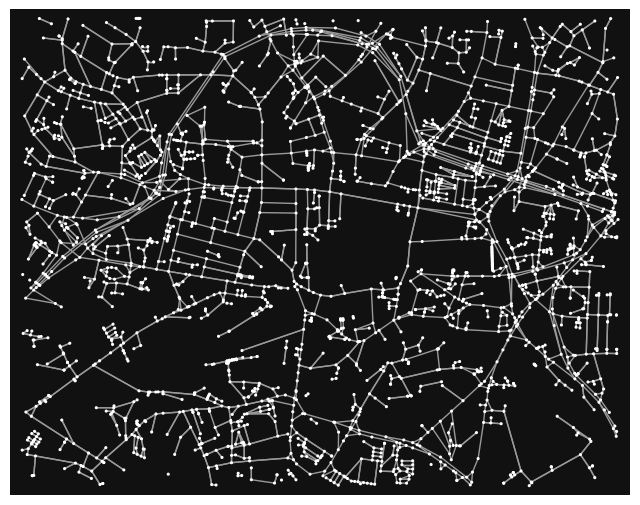

In [20]:
fig, ax = ox.plot_graph(ors_graph, node_size=5)

### Betweenness Centrality

#### Calculate betweenness centrality using distance

In [21]:
bc_length = nx.edge_betweenness_centrality(ox.get_digraph(ors_graph), weight="length")

In [22]:
centrality_distance_df = pd.DataFrame(index=bc_length.keys(), data=bc_length.values())
centrality_distance_df = centrality_distance_df.reset_index()
centrality_distance_df.columns = ['u', 'v', 'centrality_distance']
centrality_distance_df = centrality_distance_df.set_index(['u', 'v'])

#### Calculate betweenness centrality using travel time

In [23]:
bc_traveltime = nx.edge_betweenness_centrality(ox.get_digraph(ors_graph), weight="travel_time")

In [24]:
centrality_duration_df = pd.DataFrame(index=bc_traveltime.keys(), data=bc_traveltime.values())
centrality_duration_df = centrality_duration_df.reset_index()
centrality_duration_df.columns = ['u', 'v', 'centrality_duration']
centrality_duration_df = centrality_duration_df.set_index(['u', 'v'])

In [25]:
graph_with_traveltime_df = ox.graph_to_gdfs(ors_graph)

In [26]:
edges_df = graph_with_traveltime_df[1][['geometry', 'travel_time']]
edges_df = edges_df.reset_index().set_index(['u', 'v'])

In [27]:
centrality_gdf = centrality_duration_df.join(edges_df)
centrality_gdf = gpd.GeoDataFrame(centrality_gdf, crs=4326)

In [28]:
centrality_gdf = centrality_gdf.join(centrality_distance_df)

#### Compare betweenness centrality using distance and duration.

In [29]:
map_center = points_df.dissolve().centroid[0]
m = folium.plugins.DualMap(location=[map_center.y, map_center.x], 
                           tiles='cartodbpositron', 
                           zoom_start=13)
centrality_gdf.explore(column='centrality_distance', cmap='magma_r', m=m.m1)
centrality_gdf.explore(column='centrality_duration', cmap='magma_r', m=m.m2)
#badneuenahr_df.explore(m=m)
m

/var/folders/qm/4mw6rbgx6bb0wq2hb4l1hzf0yhklhv/T/ipykernel_28143/3563652099.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = points_df.dissolve().centroid[0]


## Betweenness centrality for healthcare accessibility

An adapted version of betweeness centrality was used to find critical roads for health care acessibility. ([Petricola et al., 2022](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-022-00315-2))

#### Download hospitals from OSM

We will use the [ohsome API](https://docs.ohsome.org/ohsome-api/v1/) to download hospitals from OSM.  

In [34]:
from ohsome import OhsomeClient

In [35]:
ohsome_client = OhsomeClient()

In [36]:
_, graph_df = ox.graph_to_gdfs(ors_graph)

In [37]:
hospitals = ohsome_client.elements.centroid.post(bboxes=graph_df.total_bounds, 
                                                 filter='amenity=hospital and (type:node or type:way)')

In [38]:
hospitals_df = hospitals.as_dataframe()

In [39]:
hospitals_df.explore()

#### Create grid of start points

In [40]:
start_points = create_grid(edges_df.total_bounds, 0.001, 0.001)

#### Calculating a route

In [41]:
routes = []
for i, h in hospitals_df.iterrows():
    print(h)
    for i, s in start_points.iterrows():
        orig = ox.nearest_nodes(ors_graph, Y=s.geometry.y, X=s.geometry.x)
        dest = ox.nearest_nodes(ors_graph, Y=h.geometry.y, X=h.geometry.x)
        try:
            route = nx.shortest_path(ors_graph, orig, dest, weight="travel_time")
        except Exception as e:
            #print(e)
            continue
        try:
            route_df = ox.utils_graph.route_to_gdf(ors_graph, route, weight='travel_time').reset_index()
        except ValueError as e:
            #print(e)
            continue
        routes.append(route_df)

geometry    POINT (-1.5522333 53.8023194)
Name: (way/23196317, 2023-08-10 20:00:00), dtype: object
geometry    POINT (-1.5542525 53.8006108)
Name: (way/913062230, 2023-08-10 20:00:00), dtype: object
geometry    POINT (-1.5570462 53.8029489)
Name: (way/99644805, 2023-08-10 20:00:00), dtype: object


In [42]:
routes_df = pd.concat(routes)

In [43]:
route_count = routes_df.groupby(['u', 'v', 'key']).count()['travel_time']
route_count.name = 'route_count'

In [44]:
nodes_df, edges_df = ox.graph_to_gdfs(ors_graph)
edges_df = edges_df.join(route_count)
edges_df['centrality'] = edges_df['route_count'] / edges_df['route_count'].max()

In [45]:
m = edges_df.explore(column='centrality',  cmap='magma_r', tiles=xyz.CartoDB.Positron)
hospitals_df.explore(m=m)

### Alternative method using ORS's route calculation

You could also generate the routes using openrouteservice instead of using `networkx`. In this way, you could use more of the ORS's features such as 

- turn restrictions
- Avoid ferries, toll roads, countries or certain polygons
- Specialized additional cost factors, such as steepness, greenness or noise

This would however require map matching the generated routes back to the network graph to calculate betweenness centrality.

### References

Petricola, S., Reinmuth, M., Lautenbach, S. et al. [Assessing road criticality and loss of healthcare accessibility during floods: the case of Cyclone Idai, Mozambique 2019.](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-022-00315-2) Int J Health Geogr 21, 14 (2022).